In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm
from string import punctuation
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akkshayk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
train_data_path = './nlp-getting-started/train.csv'
test_data_path = './nlp-getting-started/test.csv'
num_words = 10000
n_epochs = 50
batch_size = 32
max_len = 10000

In [10]:
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [11]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [14]:
train_df.shape

(7613, 5)

In [15]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [16]:
train_df['keyword'].fillna('unknown', inplace=True)
train_df['location'].fillna('unknown', inplace=True)

/var/folders/nl/z_smsjtn4rn9s4p_kp4t49k40000gn/T/ipykernel_2879/1809464961.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['keyword'].fillna('unknown', inplace=True)
/var/folders/nl/z_smsjtn4rn9s4p_kp4t49k40000gn/T/ipykernel_2879/1809464961.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

In [17]:
# check null values again
train_df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [18]:
# Lower case for consistency
train_df['text_clean'] = train_df['text'].str.lower()

In [19]:
# Remove punctuation, URLs, etc.
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # remove punctuation
    return text

train_df['text_clean'] = train_df['text_clean'].apply(clean_text)

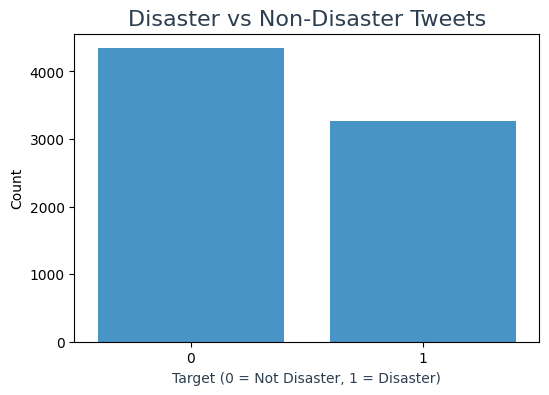

In [20]:
custom_palette = ["#3498DB", "#E74C3C"]
sns.set_palette(custom_palette)

plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train_df)
plt.title('Disaster vs Non-Disaster Tweets', color='#2C3E50', fontsize=16)
plt.xlabel('Target (0 = Not Disaster, 1 = Disaster)', color='#2C3E50')
plt.ylabel('Count')
plt.show()


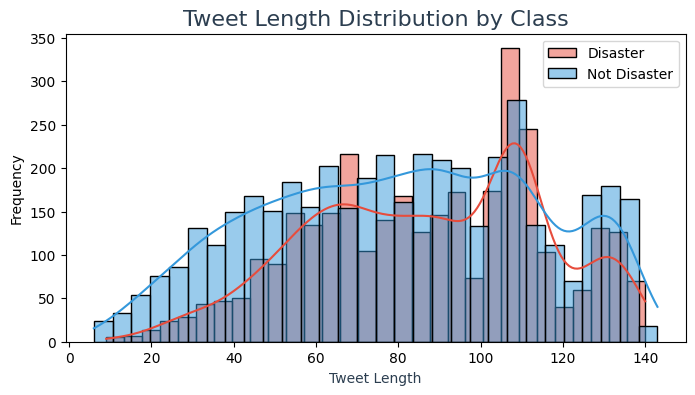

In [21]:
train_df['text_len'] = train_df['text_clean'].apply(len)

plt.figure(figsize=(8,4))
sns.histplot(train_df[train_df['target']==1]['text_len'], bins=30, color="#E74C3C", label='Disaster', kde=True)
sns.histplot(train_df[train_df['target']==0]['text_len'], bins=30, color="#3498DB", label='Not Disaster', kde=True)
plt.title("Tweet Length Distribution by Class", color="#2C3E50", fontsize=16)
plt.xlabel("Tweet Length", color="#2C3E50")
plt.ylabel("Frequency")
plt.legend()
plt.show()

/var/folders/nl/z_smsjtn4rn9s4p_kp4t49k40000gn/T/ipykernel_2879/3738910628.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")


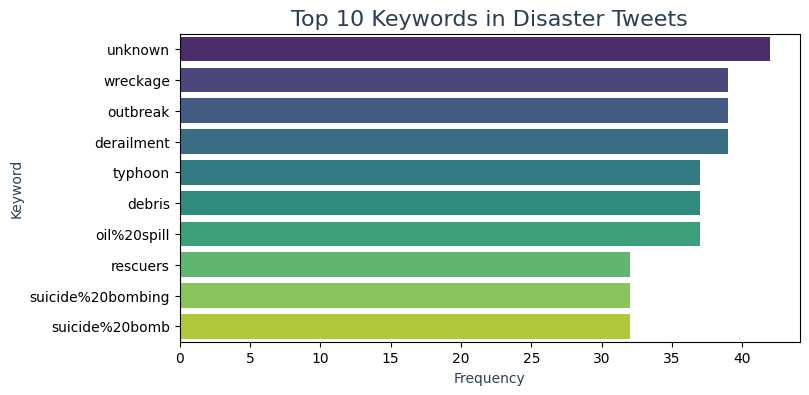

In [22]:
top_keywords = train_df[train_df['target']==1]['keyword'].value_counts().nlargest(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")
plt.title("Top 10 Keywords in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Keyword", color="#2C3E50")
plt.show()


/var/folders/nl/z_smsjtn4rn9s4p_kp4t49k40000gn/T/ipykernel_2879/1569866172.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")


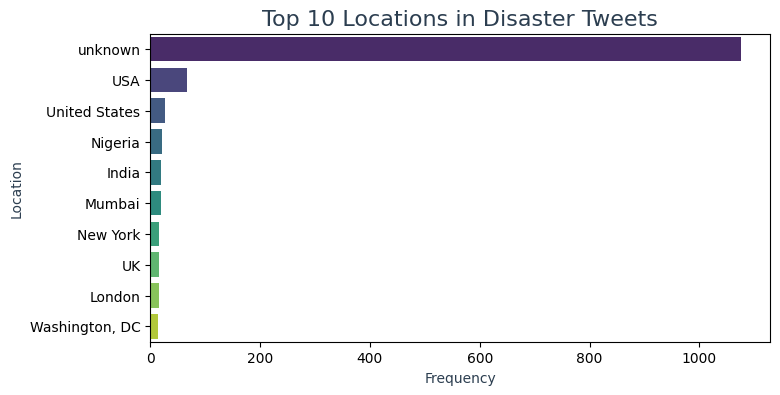

In [23]:
top_keywords = train_df[train_df['target']==1]['location'].value_counts().nlargest(10)

plt.figure(figsize=(8,4))
sns.barplot(x=top_keywords.values, y=top_keywords.index, palette="viridis")
plt.title("Top 10 Locations in Disaster Tweets", color="#2C3E50", fontsize=16)
plt.xlabel("Frequency", color="#2C3E50")
plt.ylabel("Location", color="#2C3E50")
plt.show()

In [28]:
def pre_process(df):
    reviews = []
    stopwords_set = set(stopwords.words("english"))
    ps = PorterStemmer()
    for p in tqdm(df["text"]):
        # convert to lowercase 
        p = p.lower()
        
        # remove punctuation and additional empty strings
        p = ''.join([c for c in p if c not in punctuation])
        reviews_split = p.split()
        reviews_wo_stopwords = [word for word in reviews_split if not word in stopwords_set]
        reviews_stemm = [ps.stem(w) for w in reviews_wo_stopwords]
        p = ' '.join(reviews_stemm)
        reviews.append(p)
    return reviews

train_df['text_pp'] = pre_process(train_df)
test_df['text_pp'] = pre_process(test_df)

100%|██████████| 3263/3263 [00:00<00:00, 5114.18it/s]


In [29]:
# compare the same phrase before and after pre-processing
print('Phrase before pre-processing: ', train_df['text'][0])
print('Phrase after pre-processing: ', train_df['text_pp'][0])

Phrase before pre-processing:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Phrase after pre-processing:  deed reason earthquak may allah forgiv us


In [30]:
X = train_df["text_pp"]
y = train_df["target"]

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_raw = test_df["text_pp"]

Word Embedding

In [35]:
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_raw)
X_train_seq = tokenizer.texts_to_sequences(X_train_raw)
X_val_seq = tokenizer.texts_to_sequences(X_val_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)

# Dynamically choose max_len (90th percentile of lengths)
sequence_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(sequence_lengths, 90))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

Models

Bidirectional LSTM

In [36]:
model_lstm = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=max_len),
    Bidirectional(LSTM(64, 
                       return_sequences=False, 
                       dropout=0.2,
                       recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [37]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=5, 
                           restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.5, 
                                            patience=5, 
                                            min_lr=1e-5)

In [39]:
model_lstm.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_lstm = model_lstm.fit(X_train_pad, 
              y_train, 
              epochs=n_epochs, 
              batch_size=batch_size,
              validation_data=(X_val_pad, y_val), 
              callbacks=[early_stop, learning_rate_reduction])

Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.6233 - loss: 0.6377 - val_accuracy: 0.7919 - val_loss: 0.4677 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8174 - loss: 0.4160 - val_accuracy: 0.7899 - val_loss: 0.4697 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8698 - loss: 0.3257 - val_accuracy: 0.7978 - val_loss: 0.4613 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8855 - loss: 0.2901 - val_accuracy: 0.7991 - val_loss: 0.4740 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8956 - loss: 0.2731 - val_accuracy: 0.7919 - val_loss: 0.5029 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9116 - loss: 0.2403 - val_accuracy: 0.6960 - val_loss: 0.7403 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9182 - loss: 0

In [40]:
def plot_evaluation(history):

    plt.figure(figsize=(18, 5))
    
    # accuracy
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4', linestyle="dashed")
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='#1f77b4')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    
    # loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='#1f77b4', linestyle="dashed")
    plt.plot(history.history['val_loss'], label='Val Loss', color='#1f77b4')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    
    plt.show()

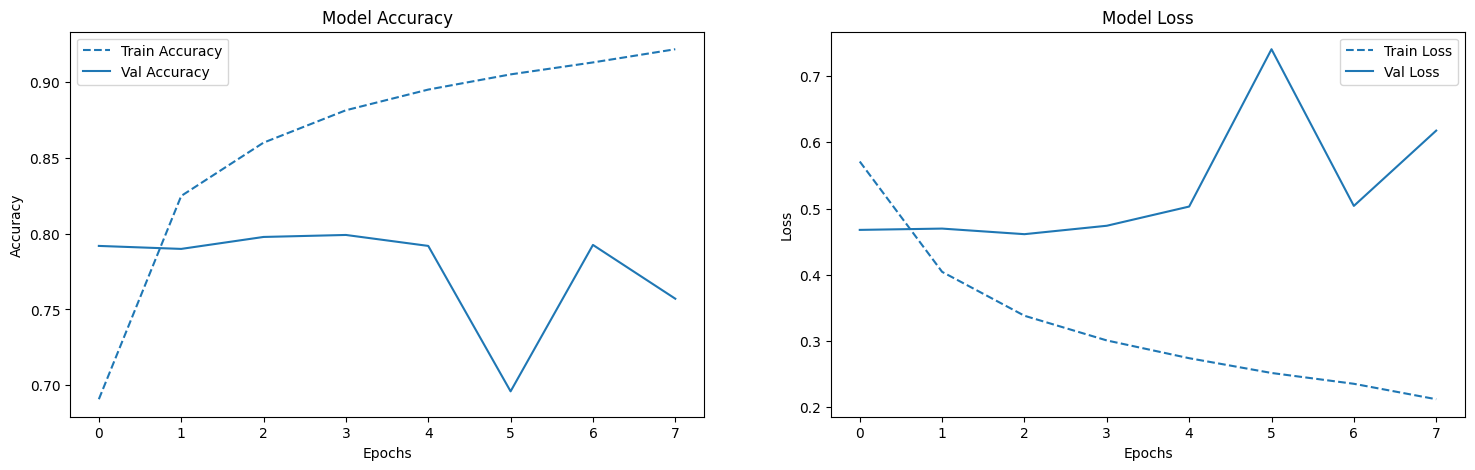

In [41]:
plot_evaluation(history_lstm)

In [42]:
predictions_lstm = (model_lstm.predict(X_test_pad) > 0.5).astype(int).flatten()
submission_lstm = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_lstm
})
submission_lstm.to_csv('submission_lstm.csv', index=False)
submission_lstm.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


Bidirectional 2xGRU

In [44]:
model_gru = Sequential([
    Embedding(input_dim=num_words, output_dim=64, input_length=max_len),
    Bidirectional(GRU(32, 
                       return_sequences=True, 
                       kernel_regularizer=l2(0.01))),
    Bidirectional(GRU(64, 
                       kernel_regularizer=l2(0.01))),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
model_gru.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history_gru = model_gru.fit(X_train_pad, 
              y_train, 
              epochs=n_epochs, 
              batch_size=batch_size,
              validation_data=(X_val_pad, y_val), 
              callbacks=[early_stop, learning_rate_reduction])


Epoch 1/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5754 - loss: 2.2467 - val_accuracy: 0.6120 - val_loss: 0.6642 - learning_rate: 0.0010
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6651 - loss: 0.6358 - val_accuracy: 0.8004 - val_loss: 0.5220 - learning_rate: 0.0010
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8291 - loss: 0.4429 - val_accuracy: 0.8043 - val_loss: 0.4766 - learning_rate: 0.0010
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8506 - loss: 0.3846 - val_accuracy: 0.7840 - val_loss: 0.4950 - learning_rate: 0.0010
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.8677 - loss: 0.3479 - val_accuracy: 0.8011 - val_loss: 0.4755 - learning_rate: 0.0010
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8792 - loss: 0.3176 - val_accuracy: 0.7925 - val_loss: 0.4858 - learning_rate: 0.0010
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.8952 - loss: 0

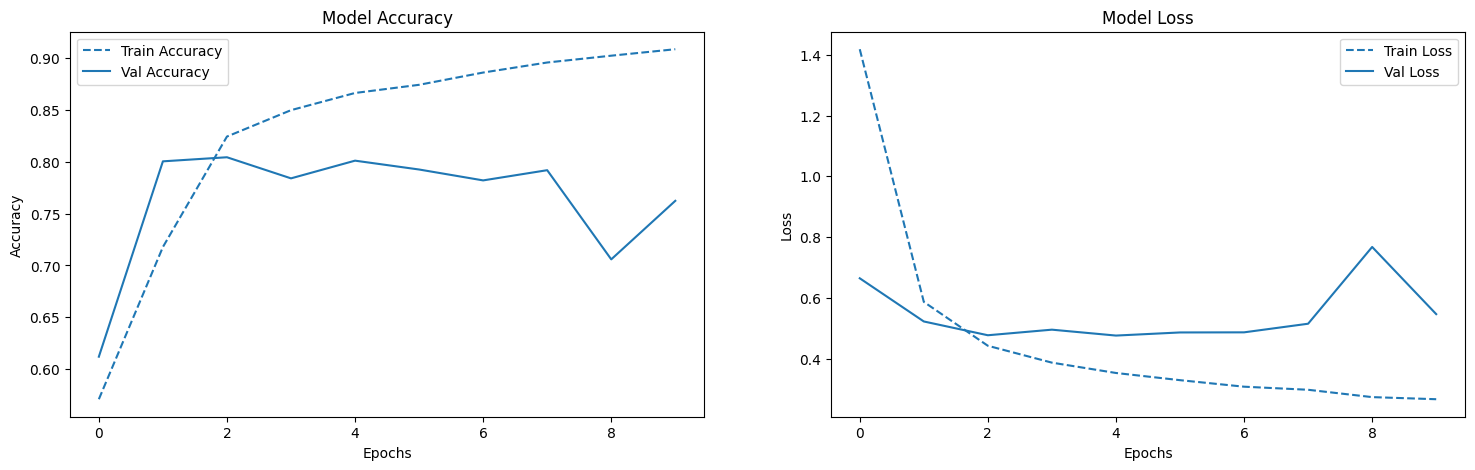

In [46]:
plot_evaluation(history_gru)

In [47]:
predictions_gru = model_gru.predict(X_test_pad).round().astype(int).reshape(3263) 
submission_gru = pd.DataFrame({
    'id': test_df['id'],
    'target': predictions_gru
})
submission_gru.to_csv('submission_gru.csv', index=False)
submission_gru.head()

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
